In [41]:
import pandas as pd
import numpy as np 
from sklearn.model_selection import train_test_split 
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Attention, Concatenate, TimeDistributed
from matplotlib import pyplot as plt
import seaborn as sns

In [20]:
data = pd.read_csv('scaled_training.csv')
data = data.iloc[:500000,:]
display(data)

,date-time,Microwave,General,Refrigerator,Washing Machine,Shower,Air Fryer
0,2022-10-03 18:43:45,0.0,0.007063,0.000000,0.0,0.0,0.0
1,2022-10-03 18:43:50,0.0,0.007219,0.000000,0.0,0.0,0.0
2,2022-10-03 18:43:55,0.0,0.007212,0.000000,0.0,0.0,0.0
3,2022-10-03 18:44:00,0.0,0.007201,0.000000,0.0,0.0,0.0
4,2022-10-03 18:44:05,0.0,0.007160,0.000000,0.0,0.0,0.0
...,...,...,...,...,...,...,...
499995,2022-11-01 22:22:55,0.0,0.025874,0.170374,0.0,0.0,0.0
499996,2022-11-01 22:23:00,0.0,0.025811,0.170435,0.0,0.0,0.0
499997,2022-11-01 22:23:05,0.0,0.025851,0.170443,0.0,0.0,0.0
499998,2022-11-01 22:23:10,0.0,0.025957,0.170555,0.0,0.0,0.0


In [21]:
for col in data.columns :
    print("Unique Values in " + col + " :" , data[col].nunique())

Unique Values in date-time : 500000
Unique Values in Microwave : 27
Unique Values in General : 54817
Unique Values in Refrigerator : 7624
Unique Values in Washing Machine : 1187
Unique Values in Shower : 1580
Unique Values in Air Fryer : 1


In [26]:
#General Power Consumption Signal as Input
x = data['General'].to_numpy()
  
# y are the Individual Appliance Signal which are to be predicted
y = data.loc[:, ['Refrigerator','Washing Machine','Shower']].to_numpy()
  
# Splitting dataset in 70-15-15 fashion for Training,Testing and Validation DataSets
x_train, x_Combine, y_train, y_Combine = train_test_split(x,y,test_size=0.3,random_state=25)
x_val, x_test, y_val, y_test = train_test_split(x_Combine,y_Combine,test_size=0.5,random_state=42) 

print(x_train , y_train)
print(x_val , y_val)
print(x_test , y_test)

[0.0361786  0.03195664 0.01231262 ... 0.03641411 0.03180699 0.02645533] [[0.1649566  0.         0.        ]
 [0.17170529 0.         0.        ]
 [0.         0.         0.        ]
 ...
 [0.17197146 0.         0.        ]
 [0.17149064 0.         0.        ]
 [0.1688547  0.         0.        ]]
[0.00318303 0.03096309 0.03111519 ... 0.01044451 0.03349357 0.03204618] [[0.         0.         0.        ]
 [0.16691423 0.         0.        ]
 [0.17076082 0.         0.        ]
 ...
 [0.         0.         0.        ]
 [0.18448144 0.         0.        ]
 [0.17240077 0.         0.        ]]
[0.03242643 0.02338024 0.02360594 ... 0.02614991 0.00801584 0.03061842] [[0.1744185  0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]
 ...
 [0.17209167 0.         0.        ]
 [0.         0.         0.        ]
 [0.16732637 0.         0.        ]]


In [27]:
print(x_train.shape , y_train.shape)

(350000,) (350000, 3)


In [24]:
# Parameters
window_size = 100  # Number of time steps in each window

# Create sliding windows
def create_sliding_windows(data, window_size):
    windows = []
    for i in range(len(data) - window_size + 1):
        windows.append(data[i:i+window_size])
    return np.array(windows)

x_train = create_sliding_windows(x_train, window_size)
x_train = np.expand_dims(x_train, axis=2)  # Add feature dimension

# Example shapes
print("Input shape:", x_train.shape)  # (number_of_windows, window_size, 1)

Input shape: (349901, 100, 1)


In [25]:
x_val = create_sliding_windows(x_val, window_size)
x_val = np.expand_dims(x_val, axis=2)
x_test = create_sliding_windows(x_test, window_size)
x_test = np.expand_dims(x_test, axis=2) 

In [8]:
print(x_val.shape)  # (number_of_windows, window_size, 1)

(74901, 100, 1)


In [9]:
print(y_train.shape)

(350000, 3)


In [10]:
def create_sliding_windows_y(data, window_size):
    num_windows = len(data) - window_size + 1
    shape = (num_windows, window_size, data.shape[1])
    strides = (data.strides[0], data.strides[0], data.strides[1])
    windows = np.lib.stride_tricks.as_strided(data, shape=shape, strides=strides)
    return windows

In [11]:
y_train = create_sliding_windows_y(y_train, window_size)
print("Target shape:", y_train.shape)  # (number_of_windows, window_size, 4)

Target shape: (349901, 100, 3)


In [12]:
y_val = create_sliding_windows_y(y_val, window_size)
print("Target shape:", y_val.shape)  # (number_of_windows, window_size, 4)

Target shape: (74901, 100, 3)


In [13]:
y_test = create_sliding_windows_y(y_test, window_size)
print("Target shape:", y_test.shape)  # (number_of_windows, window_size, 4)

Target shape: (74901, 100, 3)


In [14]:
# Define the Attention layer
class AttentionLayer(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(shape=(input_shape[-1], input_shape[-1]),
                                 initializer='random_normal', trainable=True)
        self.b = self.add_weight(shape=(input_shape[-1],),
                                 initializer='random_normal', trainable=True)
        self.V = self.add_weight(shape=(input_shape[-1], 1),
                                 initializer='random_normal', trainable=True)
        super(AttentionLayer, self).build(input_shape)

    def call(self, inputs):
        score = tf.nn.tanh(tf.tensordot(inputs, self.W, axes=1) + self.b)
        attention_weights = tf.nn.softmax(tf.tensordot(score, self.V, axes=1), axis=1)
        context_vector = attention_weights * inputs
        context_vector = tf.reduce_sum(context_vector, axis=1)
        return context_vector, attention_weights

def create_model(input_shape, num_outputs):
    inputs = Input(shape=input_shape)

    # Encoder
    encoder_lstm = LSTM(128, return_sequences=True, return_state=True)
    encoder_outputs, state_h, state_c = encoder_lstm(inputs)

    # Attention
    context_vector, attention_weights = AttentionLayer()(encoder_outputs)

    # Decoder
    context_vector = tf.expand_dims(context_vector, axis=1)
    decoder_lstm = LSTM(128, return_sequences=True, return_state=True)
    decoder_outputs, _, _ = decoder_lstm(context_vector, initial_state=[state_h, state_c])

    outputs = TimeDistributed(Dense(num_outputs))(decoder_outputs)  # Ensure correct output shape

    model = Model(inputs, outputs)
    return model

# Define window size, number of features and number of outputs
window_size = 100
num_features = 1  # Assuming 1 feature for total power
num_outputs = 3  # Assuming 4 appliances

# Create the model
input_shape = (window_size, num_features)
model = create_model(input_shape, num_outputs)
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

In [15]:
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, x, y, batch_size):
        self.x = x
        self.y = y
        self.batch_size = batch_size
        self.indexes = np.arange(len(self.x))

    def __len__(self):
        return int(np.ceil(len(self.x) / self.batch_size))

    def __getitem__(self, index):
        batch_indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        batch_x = self.x[batch_indexes]
        batch_y = self.y[batch_indexes]
        return batch_x, batch_y

# Ensure data shapes are correct
x_train = x_train.reshape(-1, window_size, num_features)
y_train = y_train.reshape(-1, window_size, num_outputs)
x_val = x_val.reshape(-1, window_size, num_features)
y_val = y_val.reshape(-1, window_size, num_outputs)
x_test = x_test.reshape(-1, window_size, num_features)
y_test = y_test.reshape(-1, window_size, num_outputs)

# Create data generators
train_generator = DataGenerator(x_train, y_train, batch_size=32)
val_generator = DataGenerator(x_val, y_val, batch_size=32)
test_generator = DataGenerator(x_test, y_test, batch_size=32)

# Train the model
history = model.fit(train_generator, epochs=50, validation_data=val_generator)

# Evaluate the model
test_loss, test_mae = model.evaluate(test_generator)
print(f'Test MAE: {test_mae}')

# Predict individual appliance consumption
y_pred = model.predict(test_generator)
print(y_pred)


Epoch 1/50
10935/10935 [==============================] - 103s 9ms/step - loss: 0.0031 - mae: 0.0307 - val_loss: 0.0032 - val_mae: 0.0304
Epoch 2/50
10935/10935 [==============================] - 108s 10ms/step - loss: 0.0031 - mae: 0.0306 - val_loss: 0.0032 - val_mae: 0.0305
Epoch 3/50
10935/10935 [==============================] - 106s 10ms/step - loss: 0.0031 - mae: 0.0306 - val_loss: 0.0032 - val_mae: 0.0310
Epoch 4/50
10935/10935 [==============================] - 122s 11ms/step - loss: 0.0031 - mae: 0.0304 - val_loss: 0.0031 - val_mae: 0.0303
Epoch 5/50
10935/10935 [==============================] - 126s 12ms/step - loss: 0.0031 - mae: 0.0303 - val_loss: 0.0031 - val_mae: 0.0300
Epoch 6/50
10935/10935 [==============================] - 127s 12ms/step - loss: 0.0031 - mae: 0.0302 - val_loss: 0.0031 - val_mae: 0.0301
Epoch 7/50
10935/10935 [==============================] - 126s 12ms/step - loss: 0.0031 - mae: 0.0302 - val_loss: 0.0031 - val_mae: 0.0304
Epoch 8/50
10935/10935 [====

In [16]:
model.save('model.keras')

In [29]:
print(y_pred.shape)

(74901, 1, 3)


In [36]:
pred_df = pd.DataFrame(new_y_pred)

In [38]:
display(pred_df)

,0,1,2
0,0.083631,-0.000391,0.000155
1,0.083992,-0.000079,0.000308
2,0.083360,0.000039,0.000242
3,0.082481,0.000056,0.000152
4,0.080800,0.000029,0.000113
...,...,...,...
74896,0.080808,0.001583,0.009557
74897,0.081554,0.001470,0.009569
74898,0.082324,0.001234,0.009539
74899,0.082914,0.001389,0.009219


In [39]:
y_test_df = pd.DataFrame(y_test)
display(y_test_df)

,0,1,2
0,0.174419,0.0,0.0
1,0.000000,0.0,0.0
2,0.000000,0.0,0.0
3,0.000000,0.0,0.0
4,0.000000,0.0,0.0
...,...,...,...
74995,0.000000,0.0,0.0
74996,0.000000,0.0,0.0
74997,0.172092,0.0,0.0
74998,0.000000,0.0,0.0


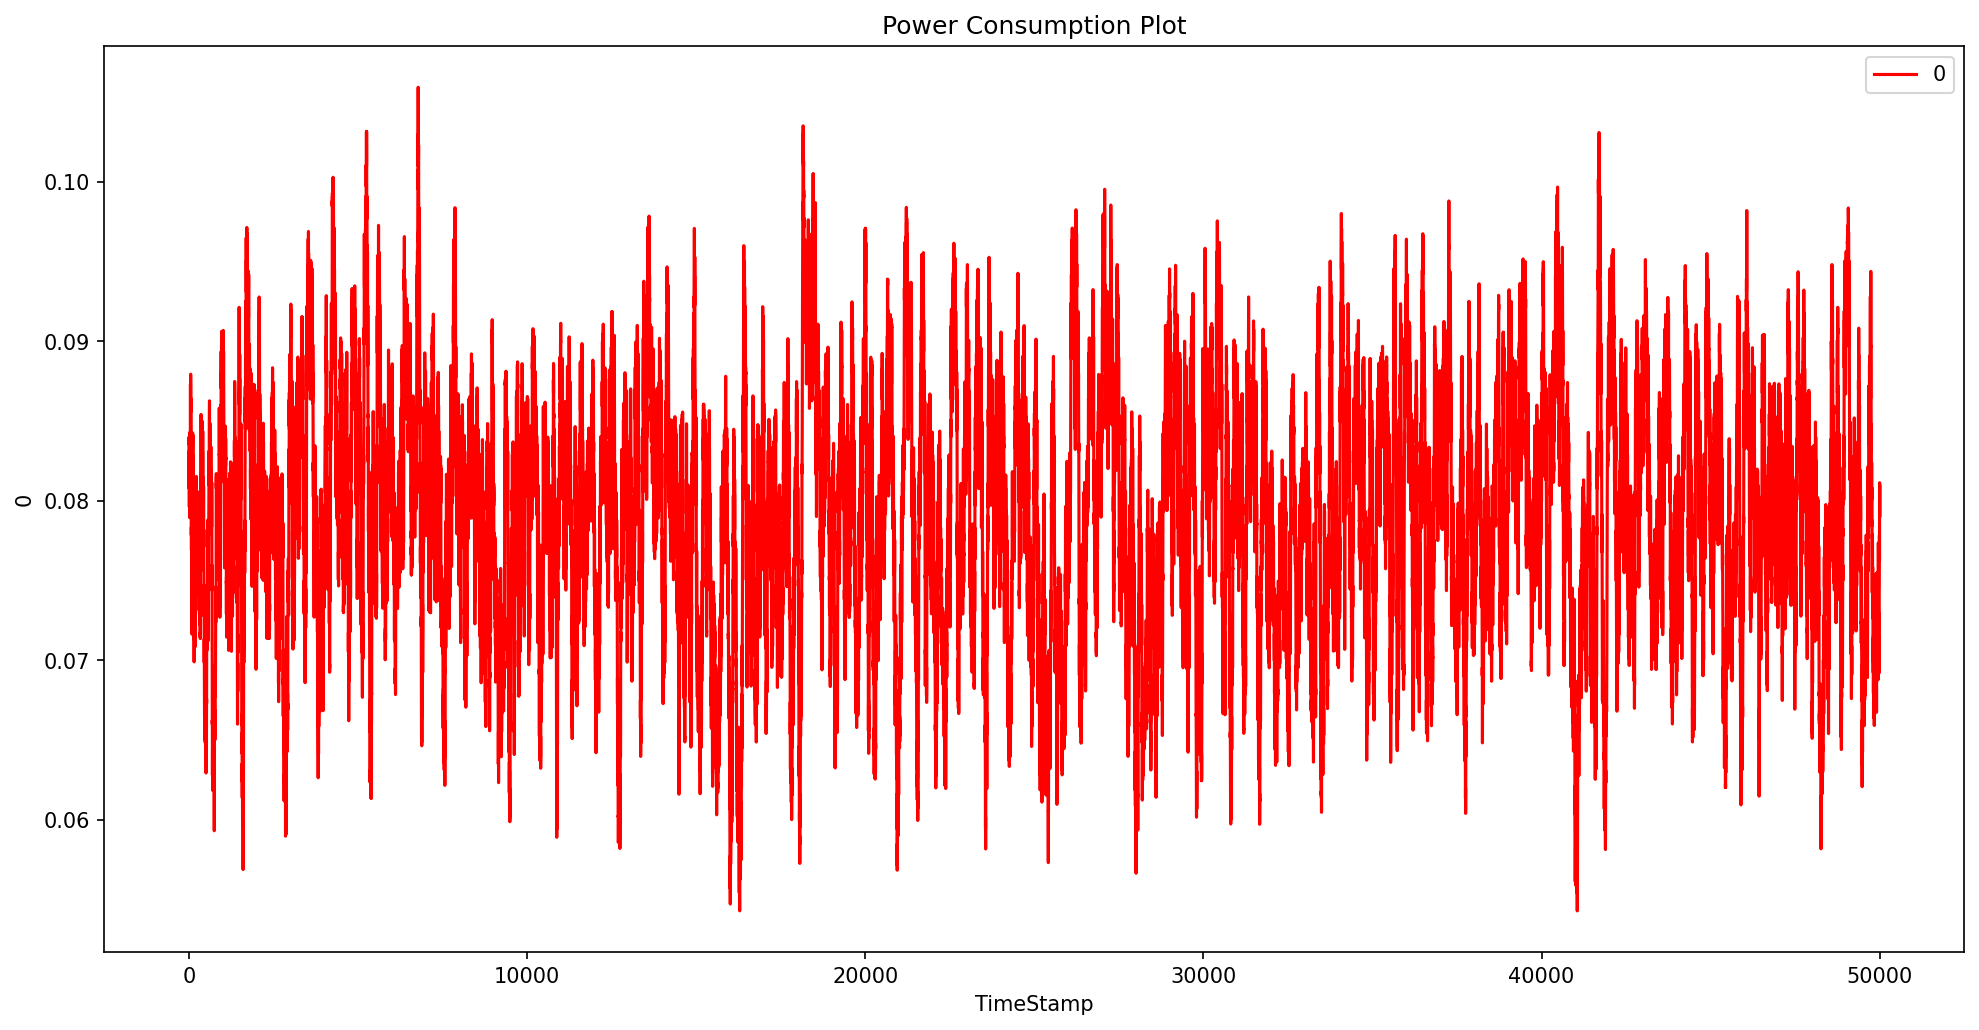

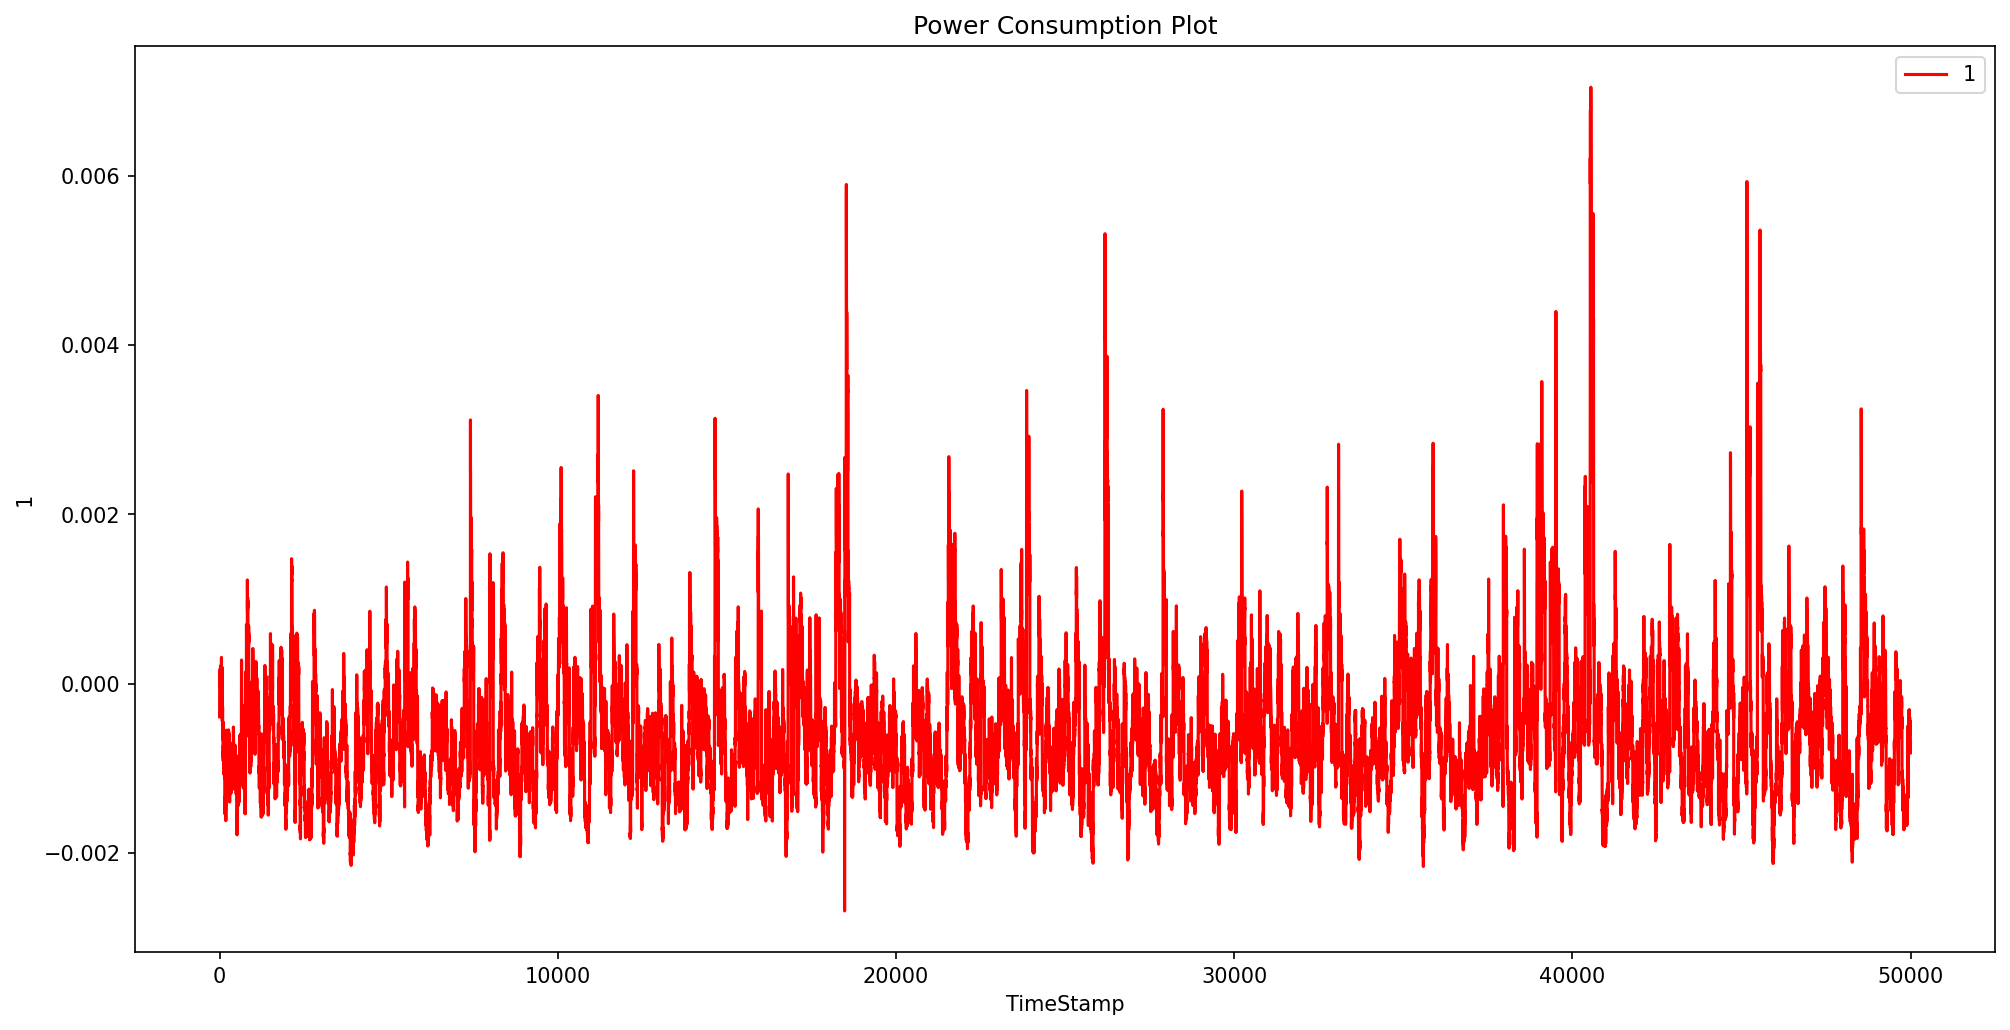

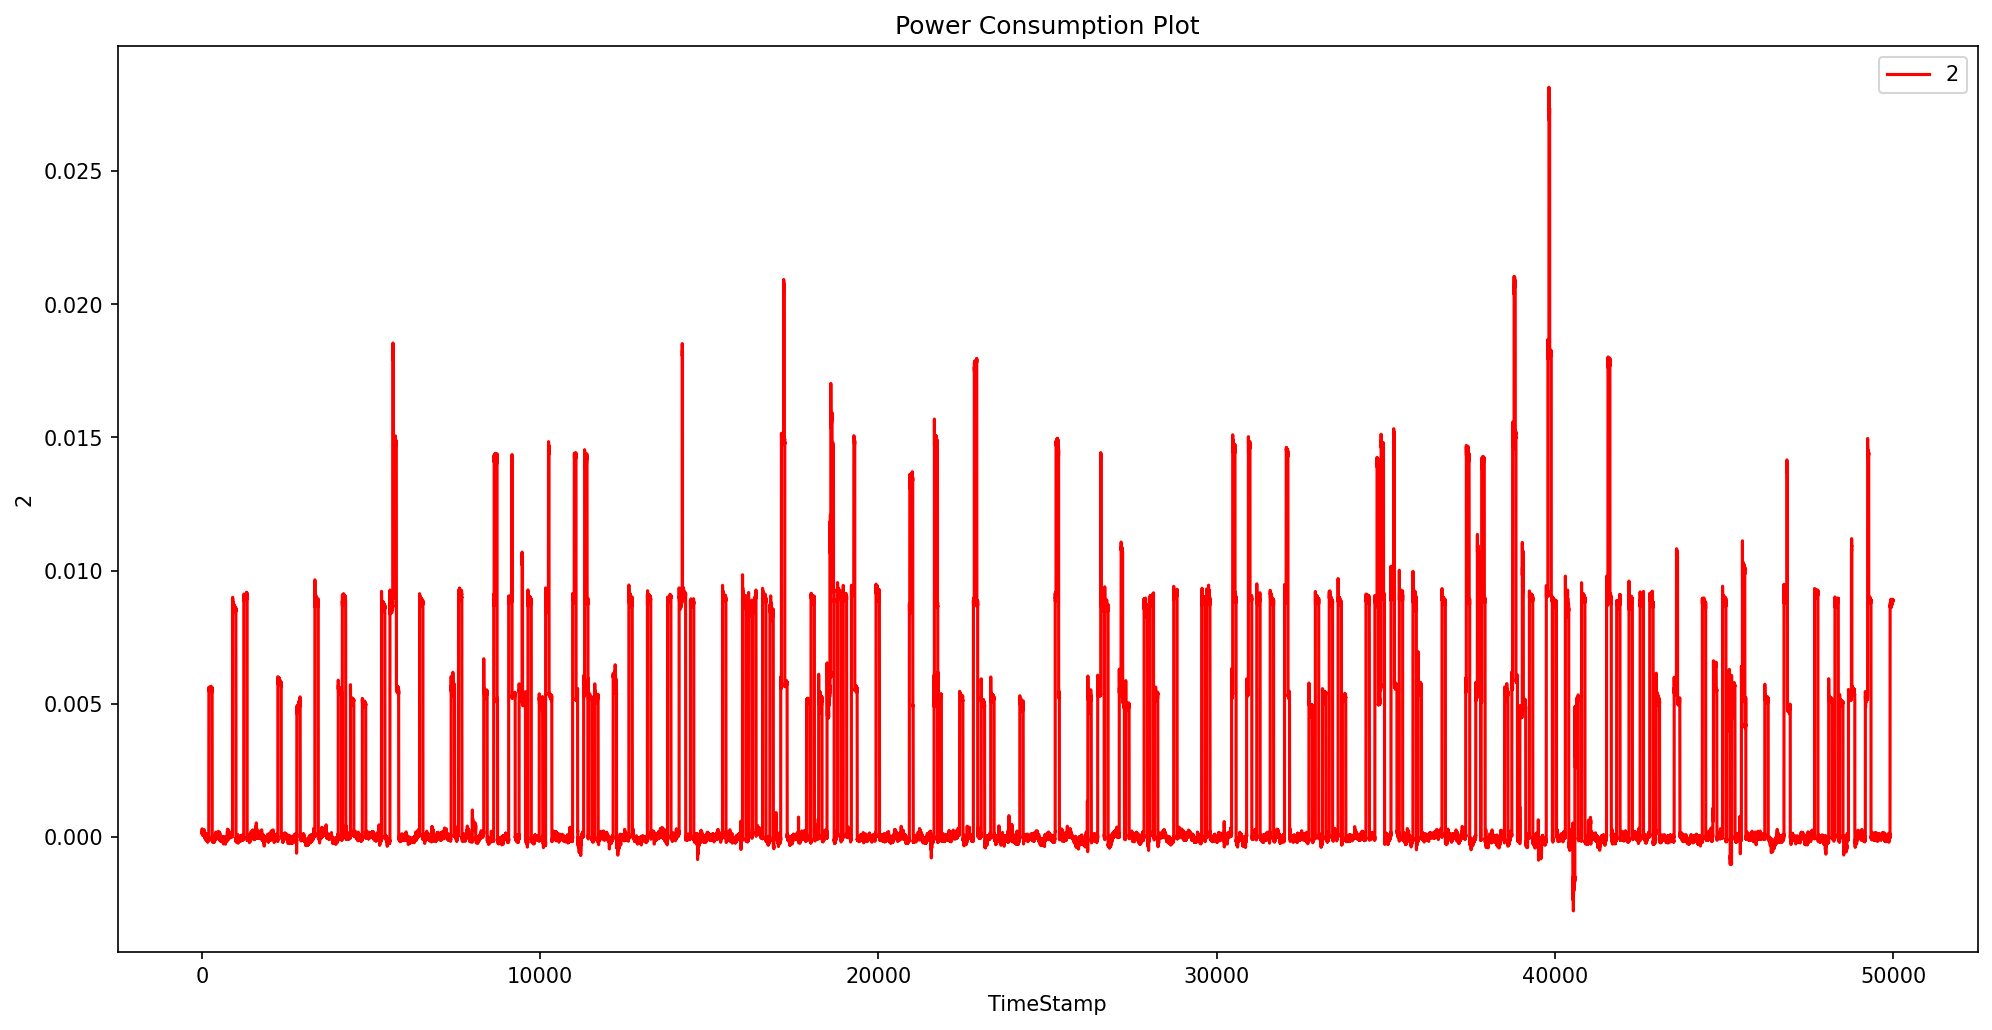

In [56]:
for col in pred_df.columns:
    plt.figure(figsize=(16, 8), dpi=150)
    pred_df[col].head(50000).plot(label=col, color='red')
    plt.title('Power Consumption Plot')
    plt.xlabel('TimeStamp')
    plt.ylabel(col)
    plt.legend()
    plt.show()

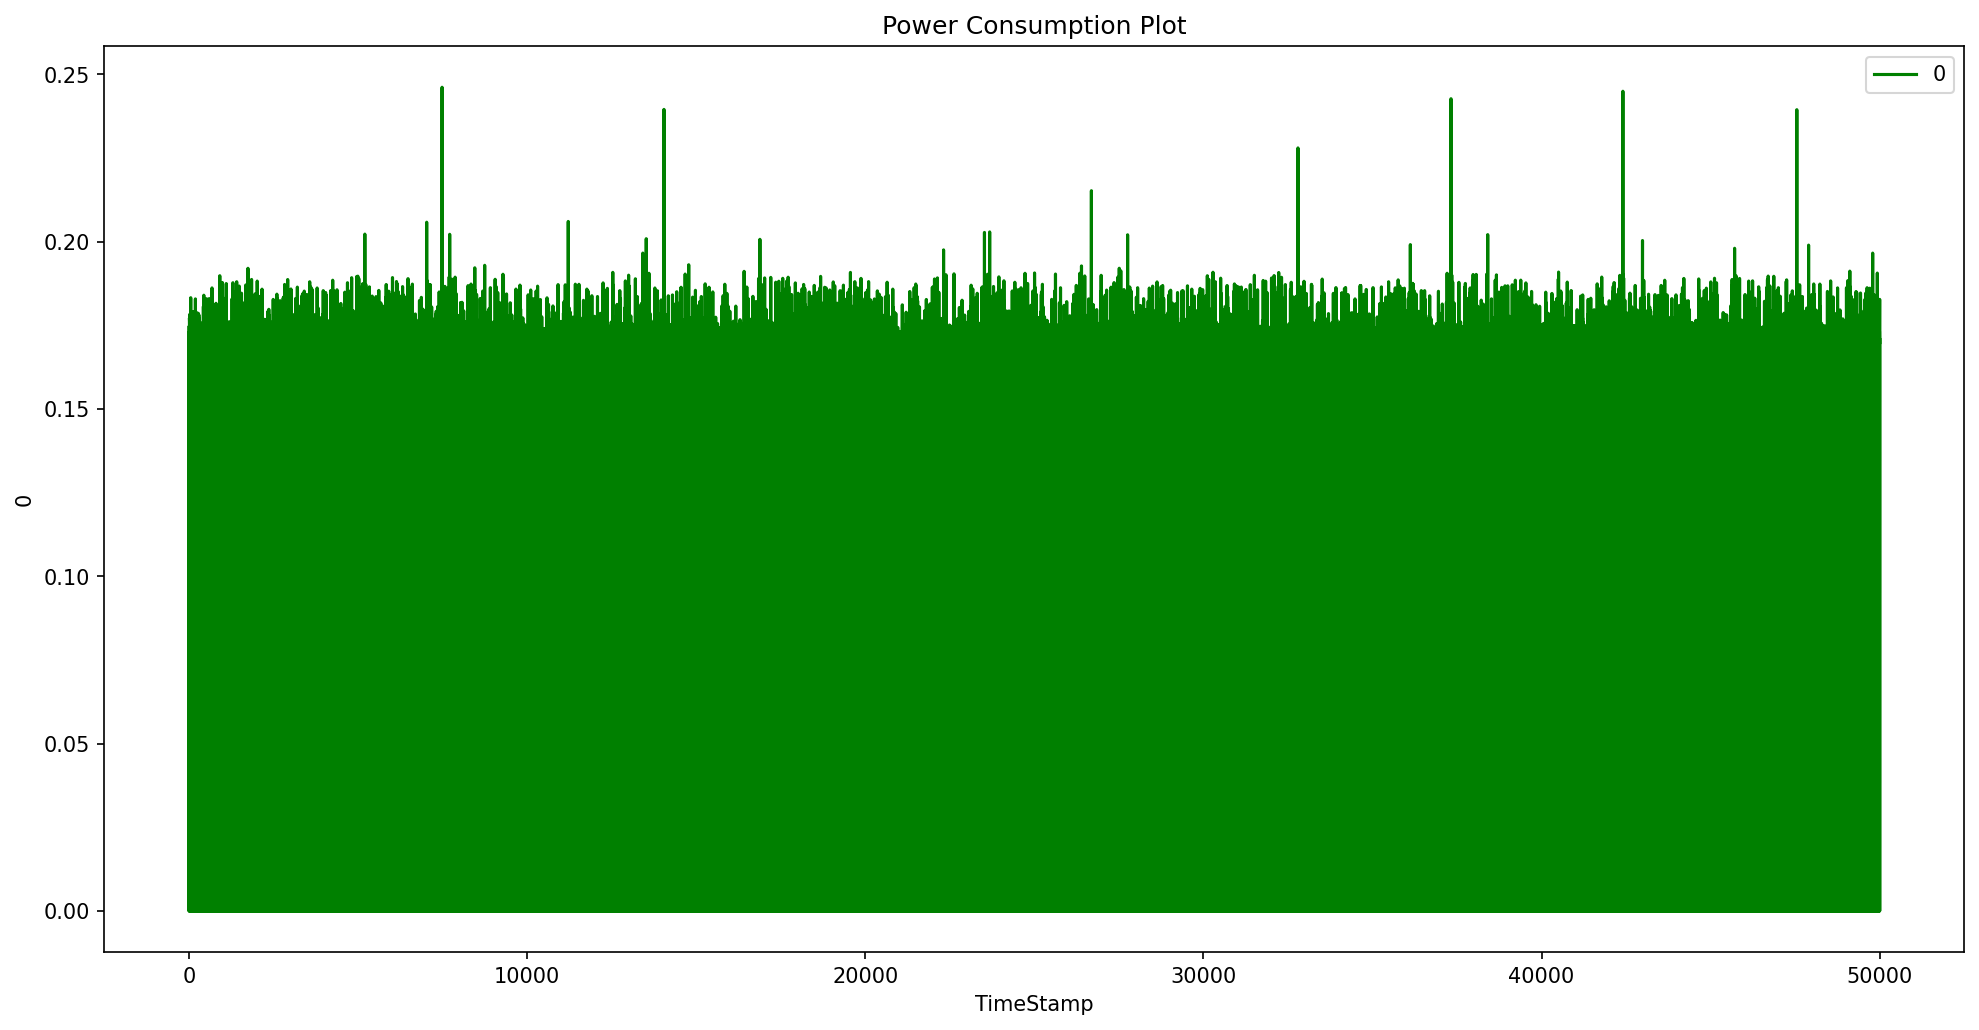

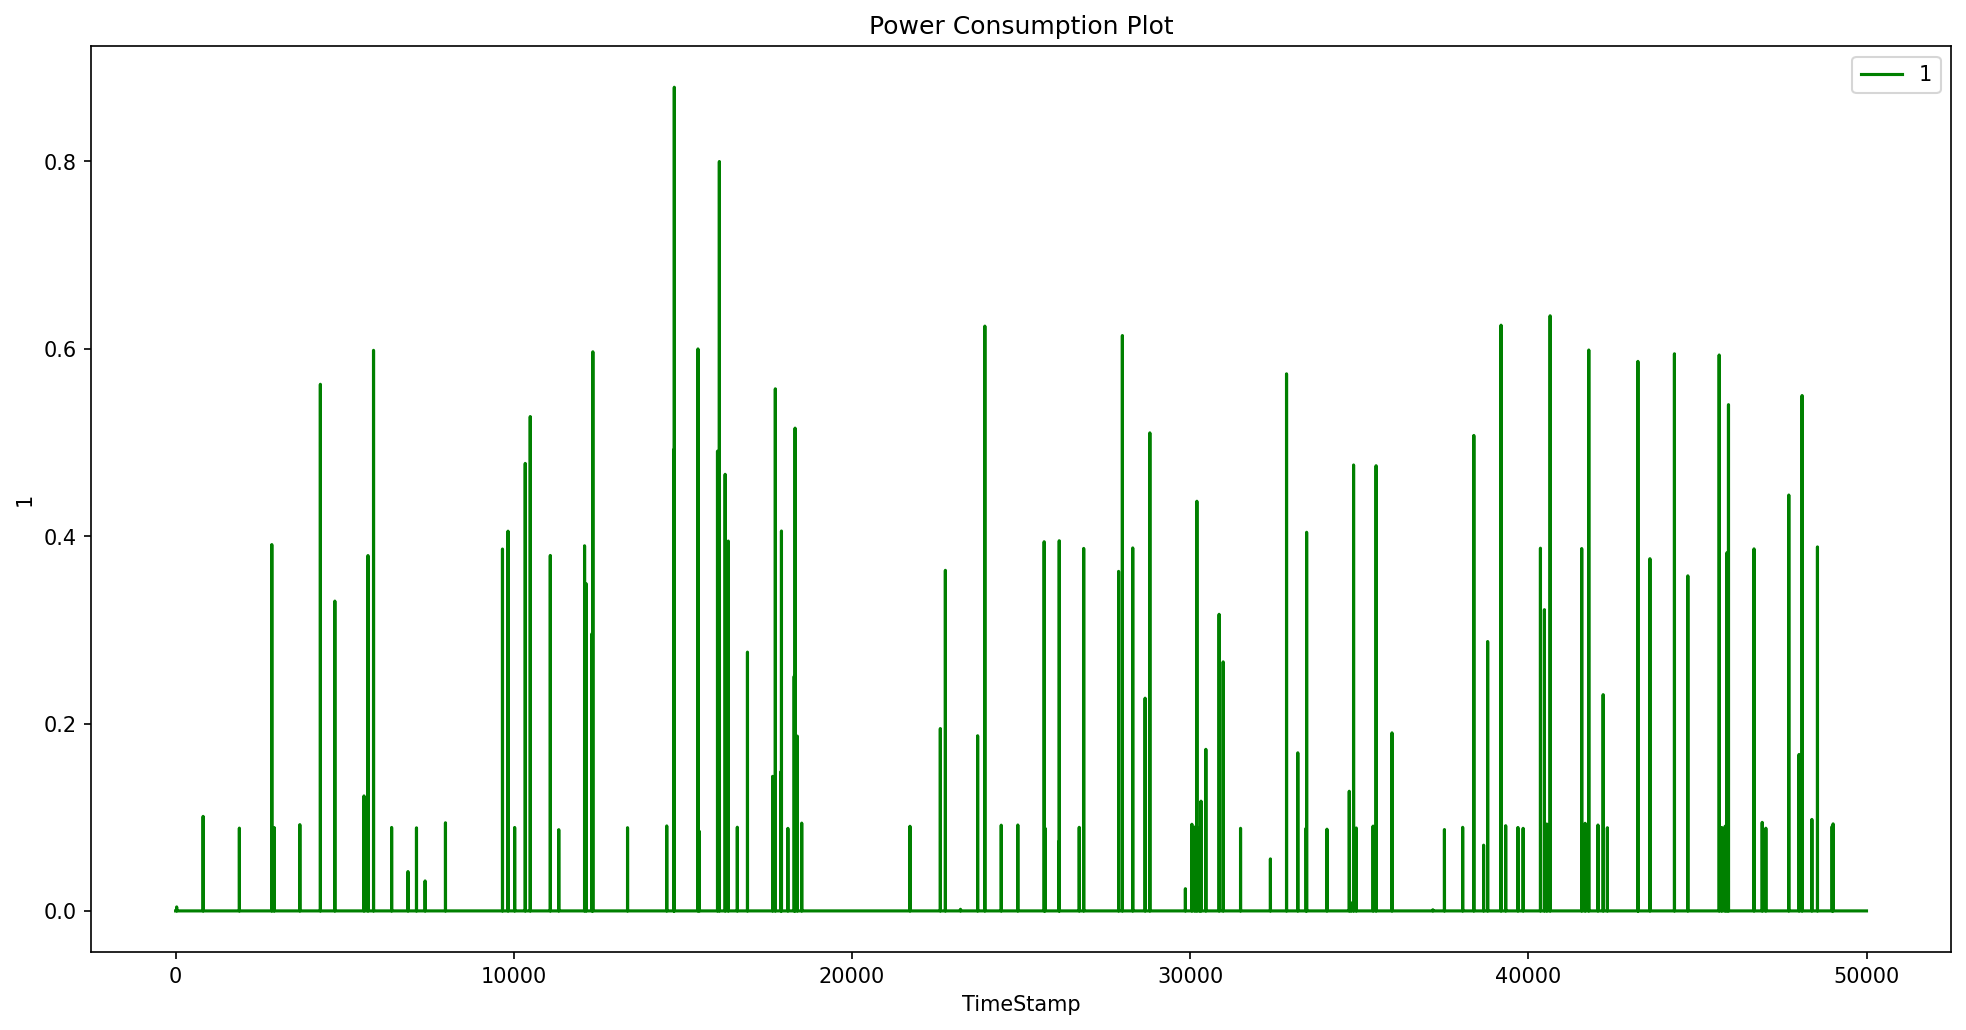

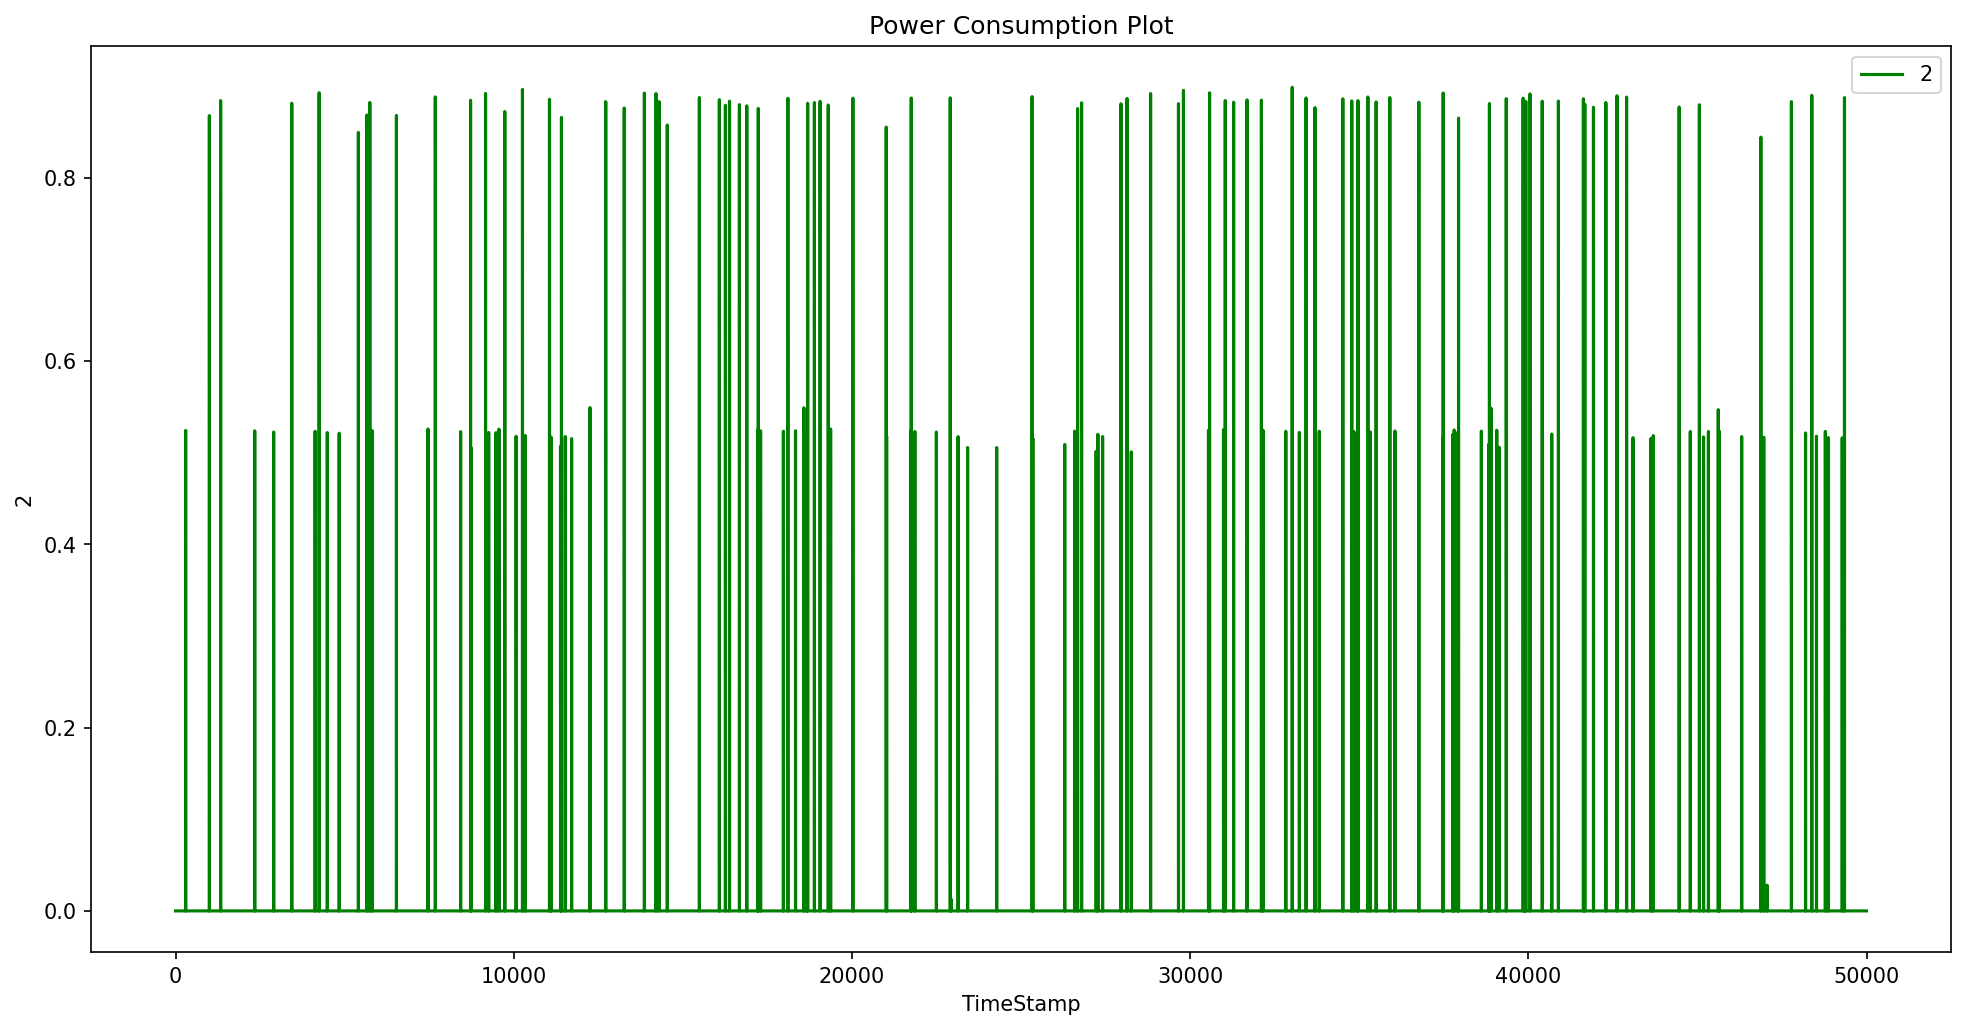

In [55]:
for col in y_test_df.columns:
    plt.figure(figsize=(16, 8), dpi=150)
    y_test_df[col].head(50000).plot(label=col, color='green')
    plt.title('Power Consumption Plot')
    plt.xlabel('TimeStamp')
    plt.ylabel(col)
    plt.legend()
    plt.show()